We scanned *a lot* of teeth for the ZMK guys and gals
Let's generate overview images of them

In [1]:
import platform
import os
import glob
import pandas
import imageio
import numpy
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
import seaborn
import dask
import dask_image.imread
from distributed import Client
client = Client(local_directory='D:\\tmp',
#                 n_workers=32,
#                 silence_logs=True
               )
# Then go to http://localhost:8787/status
from numcodecs import Blosc
from tqdm import notebook

In [2]:
# Set up figure defaults
plt.rc('image', cmap='gray', interpolation='nearest')  # Display all images in b&w and with 'nearest' interpolation
plt.rcParams['figure.figsize'] = (16, 9)  # Size up figures a bit

In [3]:
# Setup scale bar defaults
plt.rcParams['scalebar.location'] = 'lower right'
plt.rcParams['scalebar.frameon'] = False
plt.rcParams['scalebar.color'] = 'gray'

In [4]:
# Display all plots identically
lines = 1
# And then do something like
# plt.subplot(lines, numpy.ceil(len(Data) / float(lines)), c + 1)

In [5]:
# Different locations if running either on Linux or Windows
FastSSD = False
# to speed things up significantly
if 'Linux' in platform.system():
    if FastSSD:
        BasePath = os.path.join(os.sep, 'media', 'habi', 'Fast_SSD')
    else:
        BasePath = os.path.join(os.sep, 'home', 'habi', '1272')
else:
    if FastSSD:
        BasePath = os.path.join('F:\\')
    else:
        if 'anaklin' in platform.node():
            BasePath = os.path.join('S:\\')
        else:
            BasePath = os.path.join('D:\\Results')
Root = os.path.join(BasePath, 'ZMK')
print('We are loading all the data from %s' % Root)

We are loading all the data from D:\Results\ZMK


In [6]:
# Make us a dataframe for saving all that we need
Data = pandas.DataFrame()

In [7]:
Data['Folder'] = glob.glob(os.path.join(Root, 'ToothBattallion', '*'))

In [8]:
print('Up to now we scanned %s tooths' % len(Data))

Up to now we scanned 5 tooths


In [9]:
Data['LogFile'] = [sorted(glob.glob(os.path.join(f, '*.log')))[0] for f in Data['Folder']]

In [10]:
Data['Sample'] = [os.path.splitext(os.path.basename(l))[0] for l in Data['LogFile']]

In [11]:
def get_pixelsize(logfile):
    """Get the pixel size from the scan log file"""
    with open(logfile, 'r') as f:
        for line in f:
            if 'Image Pixel' in line and 'Scaled' not in line:
                pixelsize = float(line.split('=')[1])
    return(pixelsize)

In [12]:
Data['Voxelsize'] = [get_pixelsize(log) for log in Data['LogFile']]

In [13]:
if len(Data['Voxelsize'].unique())>1:
    print('We scanned the tooths with different voxel sizes')
    for vs in sorted(Data['Voxelsize'].unique()):
        print(vs, 'um for Samples ', end='')
        for c, row in Data.iterrows():
            if float(vs) == row['Voxelsize']:
                print(row.Sample, end=', ')
        print('')
else:
    print('We scanned all datasets with equal voxel size, namely %s.' % Data['Voxelsize'].unique()[0])

We scanned the tooths with different voxel sizes
5.330637 um for Samples Tooth005, 
5.569482 um for Samples Tooth004, 
7.327053 um for Samples Tooth003, 
8.559493 um for Samples Tooth001, 
8.559809 um for Samples Tooth002, 


In [14]:
def get_reconstruction_grayvalue(logfile):
    """How did we map the brightness of the reconstructions?"""
    with open(logfile, 'r') as f:
        for line in f:
            if 'Maximum for' in line:
                grayvalue = float(line.split('=')[1])
    return(grayvalue)

In [15]:
Data['Grayvalue'] = [get_reconstruction_grayvalue(log) for log in Data['LogFile']]

In [16]:
if len(Data['Grayvalue'].unique())>1:
    print('We reconstructed the datasets with different maximum gray values, namely')
    for gv in Data['Grayvalue'].unique():
        print(gv, 'for Samples ', end='')
        for c,row in Data.iterrows():
            if float(gv) == row['Grayvalue']:
                print(row.Sample, end=', ')
        print('')
else:
    print('We reconstructed all datasets with equal maximum gray value, namely %s.' % Data['Grayvalue'].unique()[0])

We reconstructed all datasets with equal maximum gray value, namely 0.18.


In [17]:
Data['PreviewImagePath'] = [sorted(glob.glob(os.path.join(f, 'rec', '*.bmp'))) for f in Data['Folder']]
Data['PreviewImage'] = [imageio.imread(pip[0])
                        if pip
                        else numpy.random.random((100,100)) for pip in Data['PreviewImagePath']]

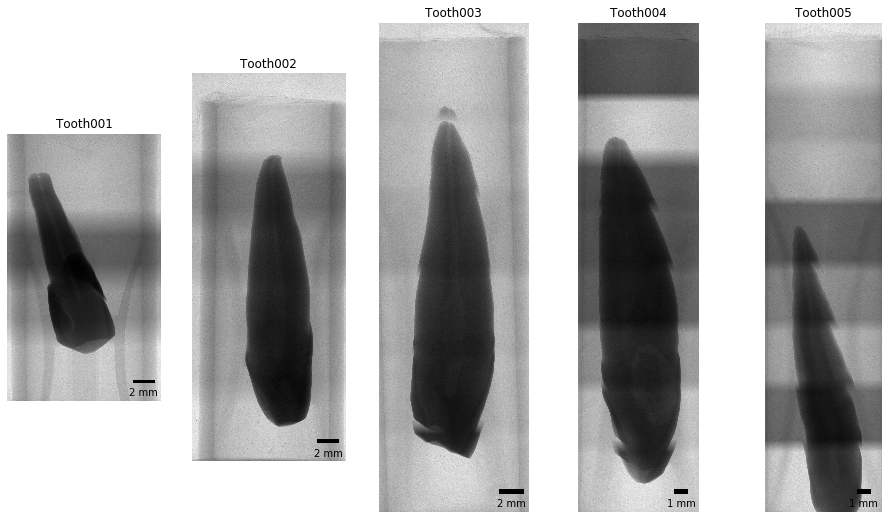

In [18]:
for c,row in Data.iterrows():
    plt.subplot(lines, numpy.ceil(len(Data) / float(lines)), c + 1)
    plt.imshow(row.PreviewImage)
    plt.title(row.Sample)
    plt.gca().add_artist(ScaleBar(row['Voxelsize'], 'um', color='black'))
    plt.axis('off')
plt.show()

In [19]:
# Get the file names of the reconstructions
Data['Reconstructions'] = [sorted(glob.glob(os.path.join(f,
                                                         'rec',
                                                         '*rec*.png'))) for f in Data['Folder']]
Data['Number of reconstructions'] = [len(r) for r in Data.Reconstructions]

In [20]:
# Drop samples which have not been reconstructed yet
# Based on https://stackoverflow.com/a/13851602
for sample in Data[Data['Number of reconstructions'] == 0]['Sample']:
    print('%s has not been reconstructed yet' % sample)
print('We remove this/these teeth temporarily')
Data = Data[Data['Number of reconstructions'] > 0]
Data.reset_index(drop=True, inplace=True)

We remove this/these teeth temporarily


In [21]:
# Convert all reconstructions into a DASK array and save them to disk
# Partially based on http://stackoverflow.com/a/39195332/323100
# and on /LungMetastasis/HighResolutionScanAnalysis.ipynb
Data['OutputNameRec'] = [os.path.join(f, sample + '_rec.zarr') for f, sample in zip(Data.Folder, Data.Sample)]
for c, row in Data.iterrows():
    if os.path.exists(row['OutputNameRec']):
        print('%2s/%s: Already saved to %s' % (c + 1,
                                               len(Data),
                                               row['OutputNameRec'][len(Root):]))
    else:
        print('%2s/%s: Reading %s reconstructions and saving to %s' % (c + 1,
                                                                       len(Data),
                                                                       row['Number of reconstructions'],
                                                                       row['OutputNameRec'][len(Root):]))
        Reconstructions = dask_image.imread.imread(os.path.join(row['Folder'], 'rec', '*rec*.png'))
        Reconstructions.to_zarr(row['OutputNameRec'],
                                overwrite=True,
                                compressor=Blosc(cname='zstd',
                                                 clevel=3,
                                                 shuffle=Blosc.BITSHUFFLE))

 1/5: Already saved to \ToothBattallion\1\Tooth001_rec.zarr
 2/5: Already saved to \ToothBattallion\2\Tooth002_rec.zarr
 3/5: Already saved to \ToothBattallion\3\Tooth003_rec.zarr
 4/5: Reading 4954 reconstructions and saving to \ToothBattallion\4\Tooth004_rec.zarr
 5/5: Reading 4159 reconstructions and saving to \ToothBattallion\5\Tooth005_rec.zarr


In [22]:
# Load the reconstructions a zarr arrays
Reconstructions = [dask.array.from_zarr(file) for file in Data['OutputNameRec']]

In [23]:
# How big are the datasets?
Data['Size'] = [rec.shape for rec in Reconstructions]

In [24]:
# The three cardinal directions
directions = ['Axial', 'Sagittal', 'Coronal']

In [25]:
# Read or calculate the middle slices, put them into the dataframe and save them to disk
for d, direction in enumerate(directions):
    Data['Mid_' + direction] = [None] * len(Reconstructions)
for c, row in notebook.tqdm(Data.iterrows(), desc='Middle images', total=len(Data)):
    for d, direction in notebook.tqdm(enumerate(directions),
                                      desc=row['Sample'],
                                      leave=False,
                                      total=len(directions)):
        outfilepath = os.path.join(row['Folder'], '%s.Middle.%s.png' % (row['Sample'], direction))
        if os.path.exists(outfilepath):
            Data.at[c,'Mid_' + direction] = imageio.imread(outfilepath)
        else:
            # Generate requested axial view
            if 'Axial' in direction:
                Data.at[c,'Mid_' + direction] = Reconstructions[c][Data['Size'][c][0]//2].compute()
            if 'Sagittal' in direction:
                Data.at[c,'Mid_' + direction] = Reconstructions[c][:,Data['Size'][c][1]//2,:].compute()
            if 'Coronal' in direction:
                Data.at[c,'Mid_' + direction] = Reconstructions[c][:,:,Data['Size'][c][2]//2].compute()
            # Save the calculated 'direction' view to disk
            imageio.imwrite(outfilepath, (Data.at[c,'Mid_' + direction]))

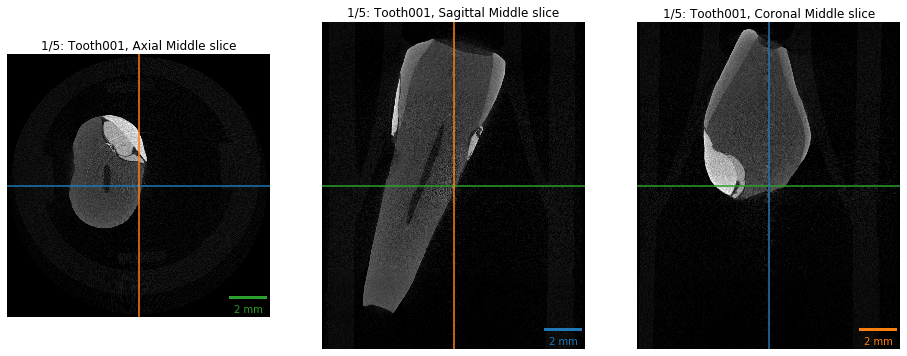

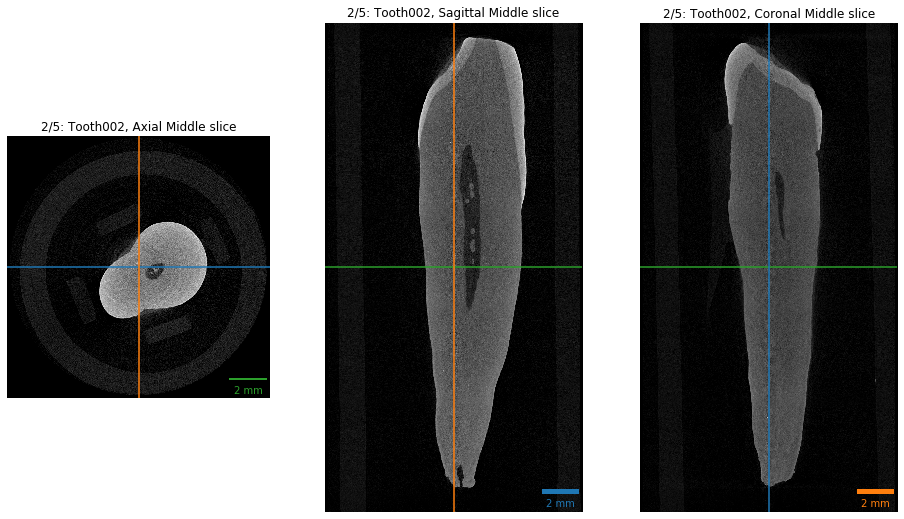

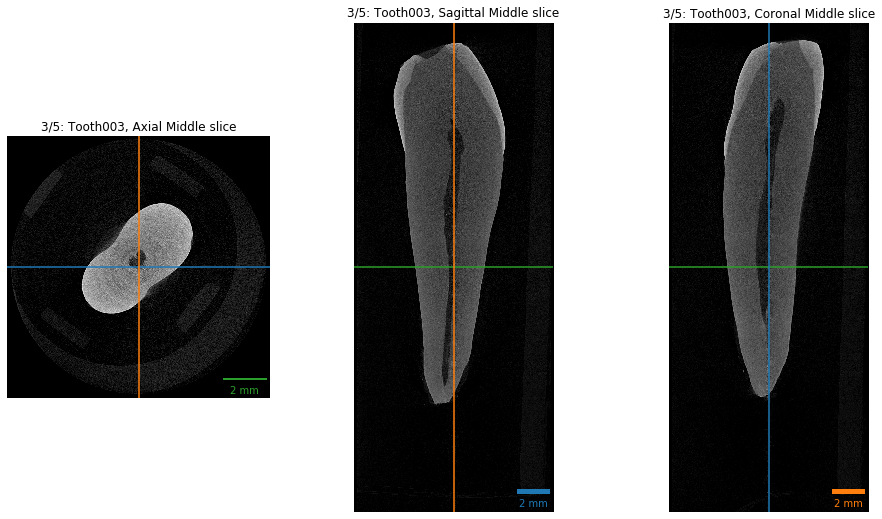

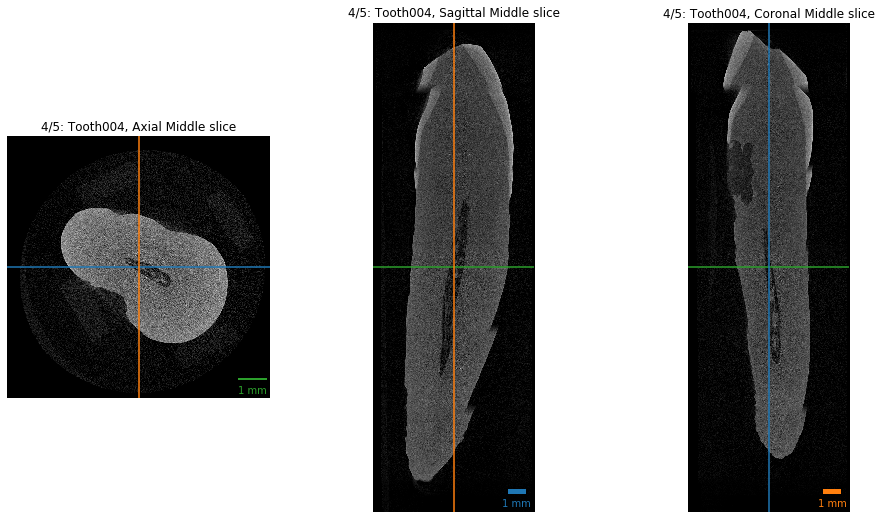

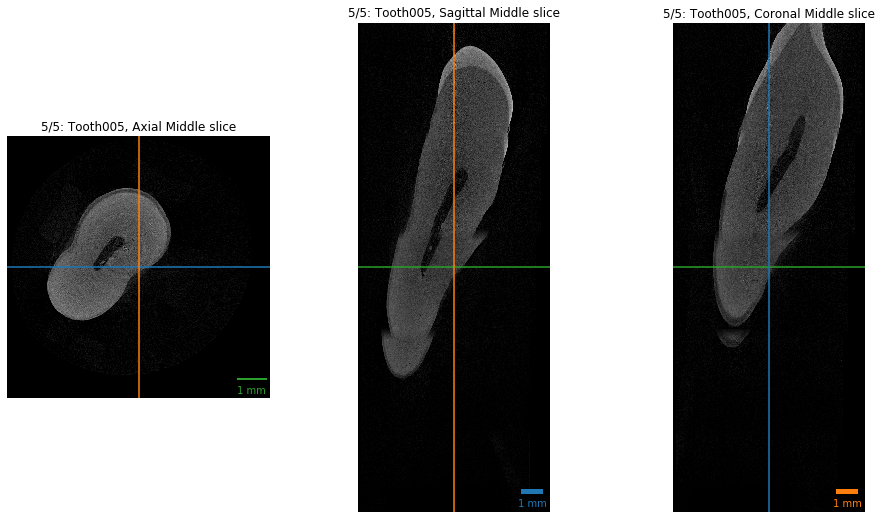

In [26]:
# Show middle slices
for c, row in Data.iterrows():
    for d, direction in enumerate(directions):
        plt.subplot(1, 3, d + 1)
        plt.imshow(row['Mid_' + direction])
        if d==0:
            plt.axhline(row.Size[1]//2, c=seaborn.color_palette()[0])
            plt.axvline(row.Size[2]//2, c=seaborn.color_palette()[1])
            plt.gca().add_artist(ScaleBar(row['Voxelsize'], 'um', color=seaborn.color_palette()[2]))
        elif d==1:
            plt.axhline(row.Size[0]//2, c=seaborn.color_palette()[2])
            plt.axvline(row.Size[d]//2, c=seaborn.color_palette()[1])
            plt.gca().add_artist(ScaleBar(row['Voxelsize'], 'um', color=seaborn.color_palette()[0]))
        else:
            plt.axhline(row.Size[0]//2, c=seaborn.color_palette()[2])
            plt.axvline(row.Size[d]//2, c=seaborn.color_palette()[0])
            plt.gca().add_artist(ScaleBar(row['Voxelsize'], 'um', color=seaborn.color_palette()[1]))
        plt.title('%s/%s: %s, %s' % (c + 1,
                                     len(Data),
                                     row['Sample'],
                                     direction + ' Middle slice'))
        plt.axis('off')
    plt.savefig(os.path.join(row['Folder'], row['Sample'] + '.MiddleSlices.png'),
                bbox_inches='tight')
    plt.show()

In [27]:
# Read or calculate the directional MIPs, put them into the dataframe and save them to disk
for d, direction in enumerate(directions):
    Data['MIP_' + direction] = [None] * len(Reconstructions)
for c, row in notebook.tqdm(Data.iterrows(), desc='MIPs', total=len(Data)):
    for d, direction in notebook.tqdm(enumerate(directions),
                                      desc=row['Sample'],
                                      leave=False,
                                      total=len(directions)):
        outfilepath = os.path.join(row['Folder'], '%s.MIP.%s.png' % (row['Sample'], direction))
        if os.path.exists(outfilepath):
            Data.at[c,'MIP_' + direction] = imageio.imread(outfilepath)
        else:
            # Generate MIP
            Data.at[c,'MIP_' + direction] = Reconstructions[c].max(axis=d).compute()
            # Save it out
            imageio.imwrite(outfilepath, Data.at[c,'MIP_' + direction].astype('uint8'))

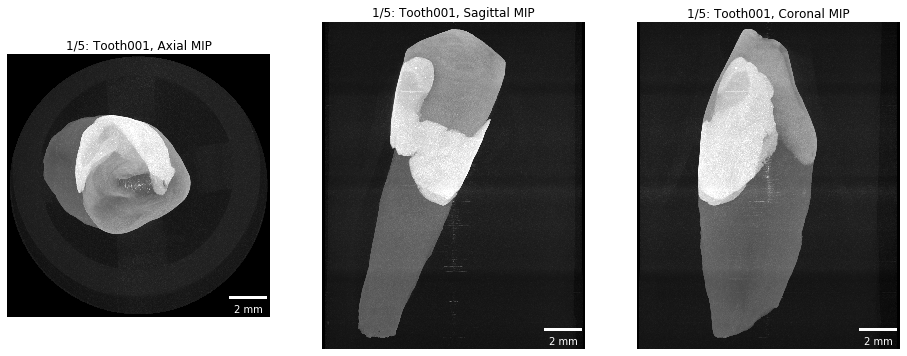

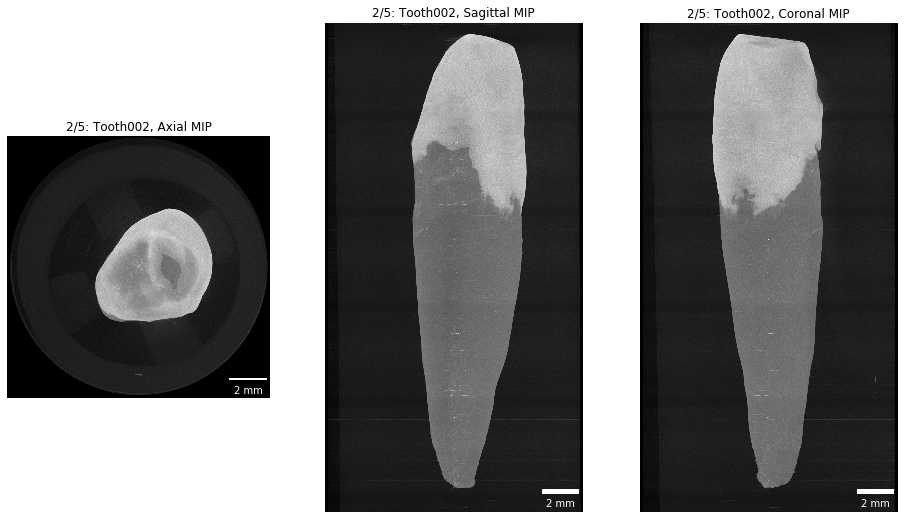

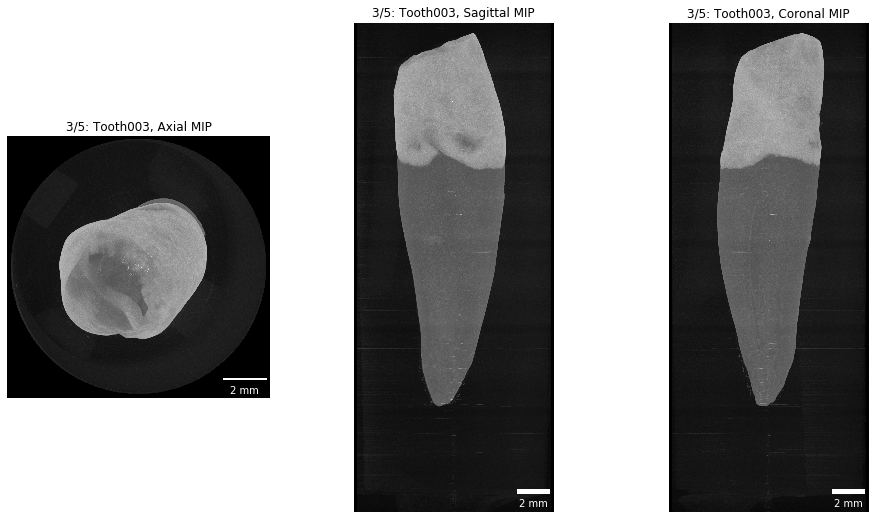

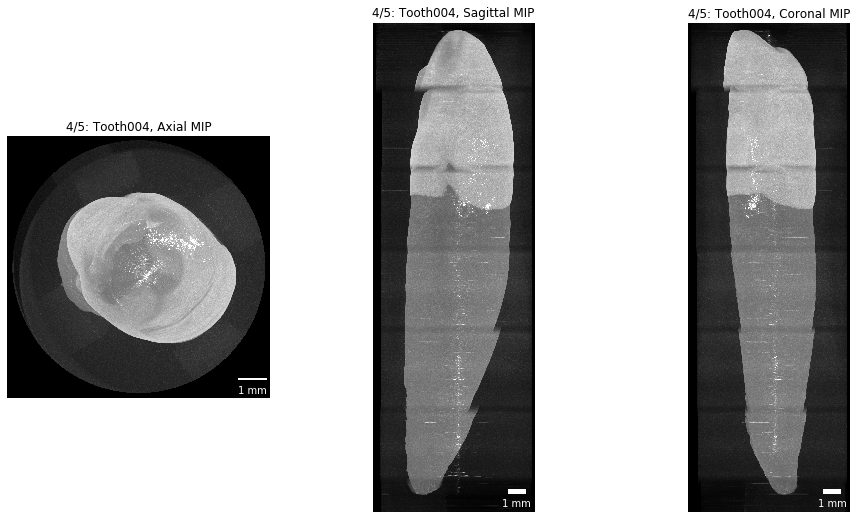

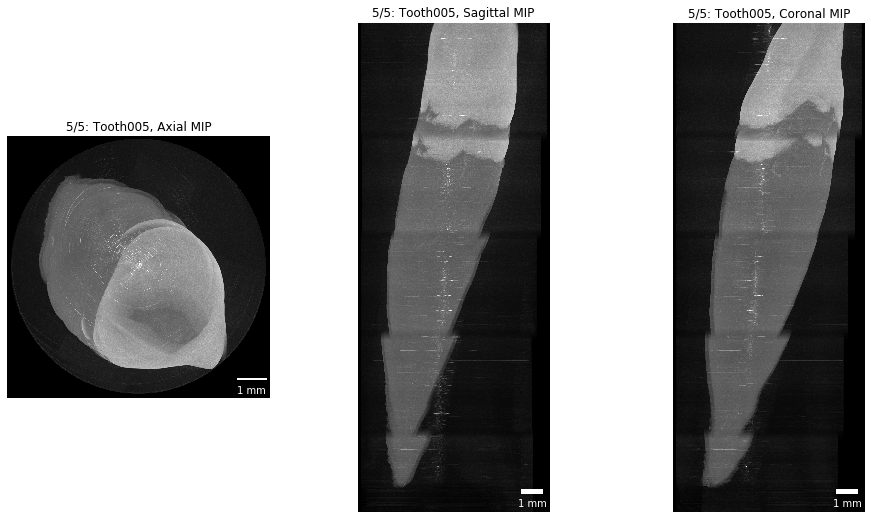

In [28]:
# Show MIP slices
for c, row in Data.iterrows():
    for d, direction in enumerate(directions):
        plt.subplot(1, 3, d + 1)
        plt.imshow(row['MIP_' + direction])
        plt.gca().add_artist(ScaleBar(row['Voxelsize'], 'um', color='white'))
        plt.title('%s/%s: %s, %s' % (c + 1,
                                     len(Data),
                                     row['Sample'],
                                     direction + ' MIP'))
        plt.axis('off')
    plt.savefig(os.path.join(row['Folder'], row['Sample'] + '.MIPs.png'),
                bbox_inches='tight')
    plt.show()

In [29]:
from itkwidgets import view  # 3d viewer

In [32]:
view(Reconstructions[1])

Viewer(geometries=[], gradient_opacity=0.22, point_sets=[], rendered_image=<itkImagePython.itkImageUC3; proxy …

In [31]:
Data.head()

Folder  \
0  D:\Results\ZMK\ToothBattallion\1   
1  D:\Results\ZMK\ToothBattallion\2   
2  D:\Results\ZMK\ToothBattallion\3   
3  D:\Results\ZMK\ToothBattallion\4   
4  D:\Results\ZMK\ToothBattallion\5   

                                         LogFile    Sample  Voxelsize  \
0  D:\Results\ZMK\ToothBattallion\1\Tooth001.log  Tooth001   8.559493   
1  D:\Results\ZMK\ToothBattallion\2\Tooth002.log  Tooth002   8.559809   
2  D:\Results\ZMK\ToothBattallion\3\Tooth003.log  Tooth003   7.327053   
3  D:\Results\ZMK\ToothBattallion\4\Tooth004.log  Tooth004   5.569482   
4  D:\Results\ZMK\ToothBattallion\5\Tooth005.log  Tooth005   5.330637   

   Grayvalue                                   PreviewImagePath  \
0       0.18  [D:\Results\ZMK\ToothBattallion\1\rec\Tooth001...   
1       0.18  [D:\Results\ZMK\ToothBattallion\2\rec\Tooth002...   
2       0.18  [D:\Results\ZMK\ToothBattallion\3\rec\Tooth003...   
3       0.18  [D:\Results\ZMK\ToothBattallion\4\rec\Tooth004...   
4       0.18  [D:\Results\ZMK\ToothBattallion\5\rec\Tooth005...   

                                        PreviewImage  \
0  [[104, 104, 104, 100, 102, 105, 106, 105, 103,...   
1  [[116, 116, 115, 116, 118, 117, 121, 116, 118,...   
2  [[115, 115, 112, 112, 116, 114, 119, 115, 114,...   
3  [[56, 56, 54, 54, 55, 54, 55, 54, 53, 51, 51, ...   
4  [[172, 172, 166, 168, 174, 171, 176, 171, 171,...   

                                     Reconstructions  \
0  [D:\Results\ZMK\ToothBattallion\1\rec\Tooth001...   
1  [D:\Results\ZMK\ToothBattallion\2\rec\Tooth002...   
2  [D:\Results\ZMK\ToothBattallion\3\rec\Tooth003...   
3  [D:\Results\ZMK\ToothBattallion\4\rec\Tooth004...   
4  [D:\Results\ZMK\ToothBattallion\5\rec\Tooth005...   

   Number of reconstructions  \
0                       2028   
1                       3105   
2                       4006   
3                       4954   
4                       4159   

                                       OutputNameRec                Size  \
0  D:\Results\ZMK\ToothBattallion\1\Tooth001_rec....  (2028, 1632, 1632)   
1  D:\Results\ZMK\ToothBattallion\2\Tooth002_rec....  (3105, 1632, 1632)   
2  D:\Results\ZMK\ToothBattallion\3\Tooth003_rec....  (4006, 1632, 1632)   
3  D:\Results\ZMK\ToothBattallion\4\Tooth004_rec....  (4954, 1632, 1632)   
4  D:\Results\ZMK\ToothBattallion\5\Tooth005_rec....  (4159, 1632, 1632)   

                                           Mid_Axial  \
0  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
1  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
2  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
3  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
4  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   

                                        Mid_Sagittal  \
0  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
1  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
2  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
3  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
4  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   

                                         Mid_Coronal  \
0  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
1  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
2  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
3  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
4  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   

                                           MIP_Axial  \
0  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
1  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
2  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
3  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
4  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   

                                        MIP_Sagittal  \
0  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
1  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
2  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
3  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
